# PDR: Stride length estimation

In [1]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code",
                                         "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from py_indoor_loc.model import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString
from compute_f import compute_step_heading
from compute_f import compute_rel_positions
from compute_f import correct_positions
from scipy.interpolate import interp1d
from dataclasses import dataclass


from py_indoor_loc.plot import plot_floor_map, plot_waypoint_location
from py_indoor_loc.sensors import compute_earth_acce_heading
from py_indoor_loc.pdr.step_detection import compute_mean, compute_local_acc_variance, compute_step_positions

In [3]:
from scipy import signal

## Reading Data

* Reading Track Data

In [4]:
TRAIN_DATA_DIR = "../../data/train/"

In [5]:
site_id, floor_id = "5cd56b6ae2acfd2d33b59ccb", "F2"

In [6]:
data_files = glob(f"{TRAIN_DATA_DIR}{site_id}/{floor_id}/*.txt")

* Reading floor map data

In [7]:
floor_info, floor_map = read_floor_data(
  f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)


In [15]:
from dataclasses import dataclass

import numpy as np
import pandas as pd


@dataclass
class PathDataCollection:
  acce: np.ndarray
  acce_uncali: np.ndarray
  gyro: np.ndarray
  gyro_uncali: np.ndarray
  magn: np.ndarray
  magn_uncali: np.ndarray
  ahrs: np.ndarray
  wifi: np.ndarray
  ibeacon: np.ndarray
  waypoint: np.ndarray


def parse_data_text(data_lines: list[str]) -> PathDataCollection:
  acce = []
  acce_uncali = []
  gyro = []
  gyro_uncali = []
  magn = []
  magn_uncali = []
  ahrs = []
  wifi = []
  ibeacon = []
  waypoint = []

  for line_data in data_lines:
    try:
      line_data = line_data.strip()
      if not line_data or line_data[0] == '#':
        continue

      line_data = line_data.split('\t')

      if line_data[1] == 'TYPE_ACCELEROMETER':
        acce.append([
            int(line_data[0]),
            float(line_data[2]),
            float(line_data[3]),
            float(line_data[4])
        ])
        continue

      if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
        acce_uncali.append([
            int(line_data[0]),
            float(line_data[2]),
            float(line_data[3]),
            float(line_data[4])
        ])
        continue

      if line_data[1] == 'TYPE_GYROSCOPE':
        gyro.append([
            int(line_data[0]),
            float(line_data[2]),
            float(line_data[3]),
            float(line_data[4])
        ])
        continue

      if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
        gyro_uncali.append([
            int(line_data[0]),
            float(line_data[2]),
            float(line_data[3]),
            float(line_data[4])
        ])
        continue

      if line_data[1] == 'TYPE_MAGNETIC_FIELD':
        magn.append([
            int(line_data[0]),
            float(line_data[2]),
            float(line_data[3]),
            float(line_data[4])
        ])
        continue

      if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
        magn_uncali.append([
            int(line_data[0]),
            float(line_data[2]),
            float(line_data[3]),
            float(line_data[4])
        ])
        continue

      if line_data[1] == 'TYPE_ROTATION_VECTOR':
        ahrs.append([
            int(line_data[0]),
            float(line_data[2]),
            float(line_data[3]),
            float(line_data[4])
        ])
        continue

      if line_data[1] == 'TYPE_WIFI':
        sys_ts = line_data[0]
        ssid = line_data[2]
        bssid = line_data[3]
        rssi = line_data[4]
        freq = line_data[5]
        lastseen_ts = line_data[6]
        wifi_data = [sys_ts, ssid, bssid, rssi, freq, lastseen_ts]
        wifi.append(wifi_data)
        continue

      if line_data[1] == 'TYPE_BEACON':
        ts = line_data[0]
        uuid = line_data[2]
        major = line_data[3]
        minor = line_data[4]
        rssi = line_data[6]
        ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
        ibeacon.append(ibeacon_data)
        continue

      if line_data[1] == 'TYPE_WAYPOINT':
        waypoint.append(
            [int(line_data[0]),
             float(line_data[2]),
             float(line_data[3])])

    except Exception as e:
      print(f"Failed to processing line: {line_data}. Caused by {str(e)}")

  acce = np.array(acce)
  acce_uncali = np.array(acce_uncali)
  gyro = np.array(gyro)
  gyro_uncali = np.array(gyro_uncali)
  magn = np.array(magn)
  magn_uncali = np.array(magn_uncali)
  ahrs = np.array(ahrs)
  wifi = np.array(wifi)
  ibeacon = np.array(ibeacon)
  waypoint = np.array(waypoint)

  path_data_collection = PathDataCollection(acce, acce_uncali, gyro,
                                            gyro_uncali, magn, magn_uncali,
                                            ahrs, wifi, ibeacon, waypoint)
  sensor_df = create_sensor_df(path_data_collection)
  sensor_ts = sensor_df["ts"].values.astype(np.int64)

  return PathDataCollection(select(acce, sensor_ts),
                            select(acce_uncali, sensor_ts),
                            select(gyro, sensor_ts),
                            select(gyro_uncali, sensor_ts),
                            select(magn, sensor_ts),
                            select(magn_uncali, sensor_ts),
                            select(ahrs, sensor_ts), wifi, ibeacon, waypoint)


def select(sensor_arr: np.ndarray, ts: np.ndarray) -> np.ndarray:
  mask = np.isin(sensor_arr[:, 0].astype(np.int64), ts)
  return sensor_arr[mask, :]


def read_data_file(data_file_path: str) -> PathDataCollection:

  with open(data_file_path, 'r', encoding='utf-8') as file:
    return parse_data_text(file.readlines())


def create_sensor_df(path_data_collection: PathDataCollection) -> pd.DataFrame:
  magn_df = pd.DataFrame(path_data_collection.magn,
                         columns=["ts", "magn_x", "magn_y", "magn_z"])
  acce_df = pd.DataFrame(path_data_collection.acce,
                         columns=["ts", "acce_x", "acce_y", "acce_z"])
  ahrs_df = pd.DataFrame(path_data_collection.ahrs,
                         columns=["ts", "ahrs_x", "ahrs_y", "ahrs_z"])

  sensor_df = pd.merge(acce_df, magn_df, on="ts", how="outer")
  sensor_df.ffill(inplace=True)

  sensor_df = pd.merge(sensor_df, ahrs_df, on="ts", how="outer")
  sensor_df.ffill(inplace=True)

  sensor_df["ts"] = sensor_df["ts"].astype(np.int64)
  sensor_df.sort_values("ts", ascending=True, inplace=True)
  return sensor_df

In [16]:
path_data_collection = read_data_file(data_files[10])

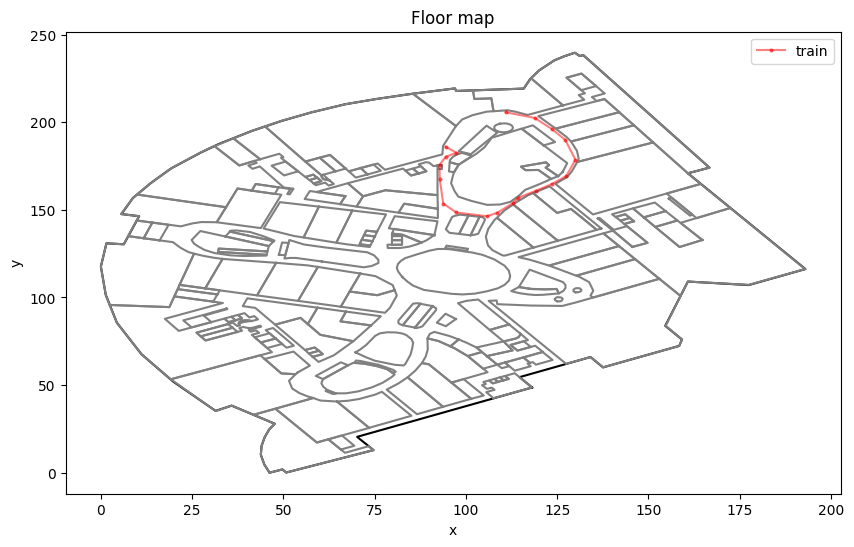

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(path_data_collection.waypoint[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## Weinberg SL Model

In [47]:
from py_indoor_loc.pdr.stride_length import WeinbergSLModel
from py_indoor_loc.pdr.step_detection import LocalAccVarianceSDModel
from py_indoor_loc.pdr.stride_length import ZUPTSLModel
from py_indoor_loc.pdr.step_detection import AngularRateSDModel 
from py_indoor_loc.sensors import compute_earth_acce_heading

In [48]:
weinberg_sl_model = WeinbergSLModel(window_size=16)
sd_model = LocalAccVarianceSDModel(window_size=4)
zupt_sl_model = ZUPTSLModel(sd_model, window_size=4)

* Pipe it to a method

In [49]:
weinberg_sl = weinberg_sl_model.predict(path_data_collection)
zupt_sl = zupt_sl_model.predict(path_data_collection)
step_mask = sd_model.predict(path_data_collection)

In [50]:
_, heading = compute_earth_acce_heading(path_data_collection.acce, path_data_collection.magn)
sensor_timestamps = path_data_collection.acce[:, 0]
heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
step_timestamps = sensor_timestamps[step_mask]
step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
step_headings[:, 1] = np.radians(step_headings[:, 1])

stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
stride_lengths[:, 0] = step_timestamps
stride_lengths[:, 1] = weinberg_sl[step_mask]

weinberg_rel_positions = compute_rel_positions(stride_lengths, step_headings)

stride_lengths[:, 1] = zupt_sl
zupt_rel_positions = compute_rel_positions(stride_lengths, step_headings)

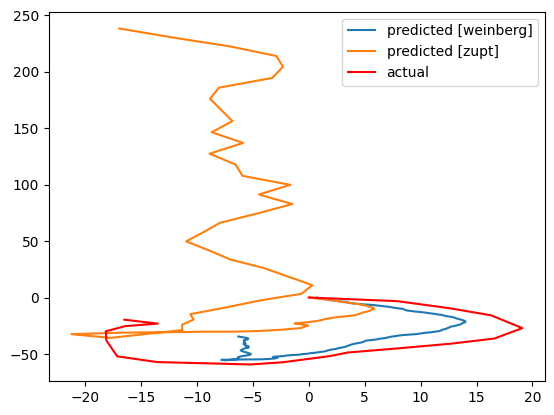

In [51]:
fig, ax = plt.subplots()

weinberg_cx = np.cumsum(weinberg_rel_positions[:, 1])
weinberg_cy = np.cumsum(weinberg_rel_positions[:, 2])

zupt_cx = np.cumsum(zupt_rel_positions[:, 1])
zupt_cy = np.cumsum(zupt_rel_positions[:, 2])

ax.plot(weinberg_cx, weinberg_cy, label="predicted [weinberg]")
ax.plot(zupt_cx, zupt_cy, label="predicted [zupt]")
ax.plot(path_data_collection.waypoint[:, 1] - path_data_collection.waypoint[0, 1], 
        path_data_collection.waypoint[:, 2] - path_data_collection.waypoint[0, 2], 
        color="red", label="actual")
ax.legend()

plt.show()